In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import numpy as np
import re

import lightgbm
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from src.config import read_train, seed_everything, ProjectPaths
from src.styles import set_styles, TXT_ACC, TXT_RESET, PALETTE
from src.DataExplorer import DataExplorer

set_styles()
seed_everything(42)

# 7 clusters vs 8 clusters

Summary:

there are 7 clusters based on KMeans clusterization method. Assuming the number of clusters as 8 splits one of the 7 clusters while leaving other clusters unchanged

In [27]:
class Clusterizer:

    def __init__(self, n_clusters, seed=42):
        self.vectorizer = None
        self.kmeans = None
        self.n_clusters = n_clusters
        self.seed = seed


    def _fit_tfidf(self, df):
        preproc_texts = df['full_text'].map(self._preprocess_text)

        self.vectorizer = TfidfVectorizer(
            max_df=0.5,
            min_df=5,
            stop_words="english",
        )
        self.vectorizer.fit(preproc_texts)

    
    def get_tfidf(self, df):
        if self.vectorizer is None:
            self._fit_tfidf(df)
        
        preproc_texts = df['full_text'].map(self._preprocess_text)
        tfidf = self.vectorizer.transform(preproc_texts)
        features = self.vectorizer.get_feature_names_out()
        return tfidf, features
    

    def _fit_kmeans_clusters(self, tfidf):
        self.kmeans = KMeans(
            n_clusters=self.n_clusters,
            init='k-means++', 
            n_init=10,
            random_state=self.seed,
        )
        self.kmeans.fit(tfidf)


    def get_kmeans_clusters(self, tfidf):
        if self.kmeans is None:
            self._fit_kmeans_clusters(tfidf)

        labels = self.kmeans.predict(tfidf)
        distances = self.kmeans.transform(tfidf)
        return labels, distances


    @staticmethod
    def best_reshuffling(labels0, labels1):
        n_clusters0 = len(np.unique(labels0))
        n_clusters1 = len(np.unique(labels1))
        
        count_coinside = np.zeros((n_clusters0, n_clusters1), dtype=int)
        for l0 in range(n_clusters0):
            for l1 in range(n_clusters1):
                count_coinside[l0, l1] = ((labels0 == l0) & (labels1 == l1)).sum()

        mapper = count_coinside.argmax(axis=0)
        new_labels1 = [mapper[x] for x in labels1]
        return new_labels1, count_coinside


    def _preprocess_text(self, text):
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)  # Replace multiple whitespace with a single space
        text = text.strip()  # Remove leading and trailing whitespace

        # Preserve paragraphs
        paragraphs = text.split('\n')
        paragraphs = [p.strip() for p in paragraphs if p.strip()]  # Remove empty paragraphs

        return '\n\n'.join(paragraphs)  # Join paragraphs with double newlines

In [28]:
df_train = read_train()
cl7 = Clusterizer(n_clusters=7)
tfidf, features = cl7.get_tfidf(df_train)
cl8 = Clusterizer(n_clusters=8)

clusters7,_ = cl7.get_kmeans_clusters(tfidf)
clusters8,_ = cl8.get_kmeans_clusters(tfidf)

In [29]:
print(len(features), 'features')
features

12885 features


array(['00', '000', '01', ..., 'zoomed', 'zooming', 'zygomatic'],
      dtype=object)

In [30]:
new_clusters8, count_coinside_7_8 = Clusterizer.best_reshuffling(clusters7, clusters8)
count_coinside_7_8

array([[   0, 1580,    0,    0,    0,    0, 1909,    0],
       [   0,    0,    0, 2025,    0,    0,    0,    0],
       [   0,    1, 3000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1648],
       [   0,   60,    0,    0, 1905,    0,    0,    0],
       [   0,   18,    0,    0,    0, 3073,    0,    0],
       [2088,    0,    0,    0,    0,    0,    0,    0]])

In [31]:
df_train['clusters7'] = clusters7
df_train['clusters8'] = new_clusters8

df_train[['clusters7', 'clusters8']].value_counts()

clusters7  clusters8
0          0            3489
5          5            3073
2          2            3000
6          6            2088
1          1            2025
4          4            1905
3          3            1648
4          0              60
5          0              18
2          0               1
Name: count, dtype: int64

## Cluster sizes

In [32]:
(df_train['clusters7'].value_counts() / df_train.shape[0]).sort_index()

clusters7
0    0.201595
1    0.117005
2    0.173398
3    0.095222
4    0.113538
5    0.178598
6    0.120645
Name: count, dtype: float64

# Target distribution by clusters

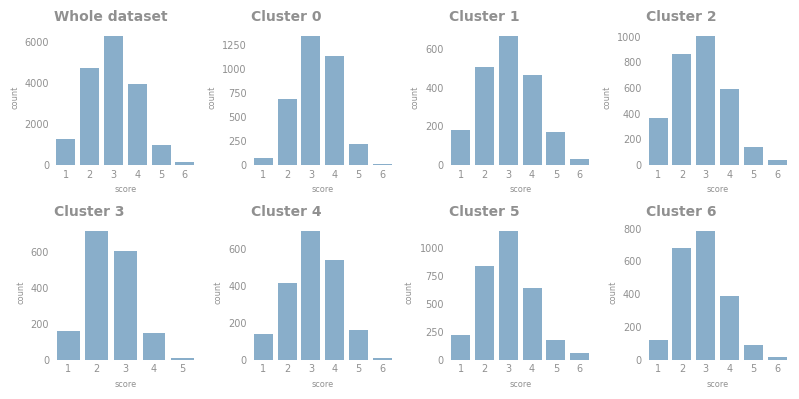

In [33]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
axes = axes.ravel()

# distribution of target for the whole dataset
ax = axes[0]
sns.barplot(df_train['score'].value_counts(), ax=ax)
ax.set_title('Whole dataset', fontsize=10)

for cl, ax in enumerate(axes[1:]):
    sns.barplot(df_train.loc[df_train['clusters7'] == cl, 'score'].value_counts(), ax=ax)
    ax.set_title(f'Cluster {cl}', fontsize=10)

plt.tight_layout()

# Summary on clusters

7 topics for essays:

0. Driverless cars
1. Voting
2. ''The Challenge of Exploring Venus''
3. Seagoing Cowboys
4. Limited car usage
5. Automatic emotion recognition
6. Face on Mars

79 essays in 'gray' zone - with 8 clusters they belong to cluster 'Driverless cars', but with 7 clusters they have different labels -> look more closely

In [34]:
for i in range(8):
    print(i)
    display(df_train.iloc[clusters8 == i])

0


,essay_id,full_text,score,label,fold,clusters7,clusters8
1,000fe60,I am a scientist at NASA that is discussing th...,3,2,4.0,6,6
50,00f3984,"The Face that is on Mars, is just a natural la...",2,1,2.0,6,6
56,0105e2e,"The face on Mars was not made by aliens, and i...",2,1,0.0,6,6
59,01267d1,"The Face was dicovered on May 24, 2001. It was...",1,0,3.0,6,6
64,014eba6,As I know from images and researches that alie...,1,0,0.0,6,6
...,...,...,...,...,...,...,...
17261,ff108ca,The face on Mars is in fact not created by ali...,3,2,4.0,6,6
17263,ff1a443,The Face on Mars is just a landform. NASA scie...,3,2,1.0,6,6
17264,ff25a21,What are your thoughts and opinions about how ...,3,2,0.0,6,6
17270,ff4bc0c,Mesa's form all of the time and they are a nat...,3,2,2.0,6,6


1


,essay_id,full_text,score,label,fold,clusters7,clusters8
2,001ab80,People always wish they had the same technolog...,4,3,1.0,0,0
10,004229b,I do not think that driverless cars are a good...,2,1,1.0,0,0
12,005a72e,I agree that driverless cars are a developing ...,4,3,2.0,0,0
15,0066c7c,My position on driveless cars are bad because ...,2,1,0.0,0,0
19,0079938,I don't like the idea of driveless cars. I fee...,3,2,2.0,0,0
...,...,...,...,...,...,...,...
17235,fece07e,In this essay I will be explaining reason from...,4,3,2.0,0,0
17242,feddb53,"""Driverless Cars Are Coming"" is an article abo...",2,1,4.0,0,0
17256,fefab6e,Driverless cars have been imagined for many ye...,2,1,1.0,0,0
17277,ff7020a,"""Teenager girl gets into a deadly car accident...",3,2,4.0,0,0


2


,essay_id,full_text,score,label,fold,clusters7,clusters8
3,001bdc0,"We all heard about Venus, the planet without a...",4,3,0.0,2,2
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,1,1.0,2,2
20,0079f2a,In the text the author uses facts that people ...,2,1,0.0,2,2
25,0087059,''The Challenge of Exploring Venus'' is a info...,1,0,1.0,2,2
27,00a3575,The challege of exploring Venus is not a great...,2,1,1.0,2,2
...,...,...,...,...,...,...,...
17297,ffbd0b4,Do you think you could suvive in another plane...,2,1,2.0,2,2
17299,ffc9095,"Venus, an extraordinary planet because of many...",3,2,4.0,2,2
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,1,4.0,2,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,0,0.0,2,2


3


,essay_id,full_text,score,label,fold,clusters7,clusters8
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2,2.0,1,1
5,0030e86,If I were to choose between keeping the electo...,4,3,2.0,1,1
13,00613e3,The election should be by popular vote of the ...,3,2,4.0,1,1
40,00d4911,"To the senator of florida,\n\nI believe that t...",4,3,3.0,1,1
41,00d576b,Well in my favor I would have the Electoral Co...,1,0,0.0,1,1
...,...,...,...,...,...,...,...
17230,feba238,The people want what the people want. My idea ...,3,2,1.0,1,1
17253,fef8172,Many people across the country would believe t...,4,3,2.0,1,1
17260,ff0aba9,Is the Electoral College a good thing? A Major...,4,3,1.0,1,1
17278,ff74f94,Votes for the president of the United States a...,5,4,0.0,1,1


4


,essay_id,full_text,score,label,fold,clusters7,clusters8
0,000d118,Many people have car where they live. The thin...,3,2,3.0,4,4
11,0047cb3,"""It's a good oppurtunity to take away stress a...",2,1,2.0,4,4
18,0072128,"Imagine a world without garages, gastations, o...",4,3,0.0,4,4
26,0098ef4,Many people in todays society tend to travel b...,4,3,1.0,4,4
31,00a6e71,Limiting car use is a great way clean up green...,2,1,1.0,4,4
...,...,...,...,...,...,...,...
17276,ff69c4a,The build up of greenhouse gases and carbon em...,3,2,4.0,4,4
17283,ff96497,"German Suburb, Life\n\nGoes On Without Cars\n\...",2,1,1.0,4,4
17285,ff988c9,Countries have started to limit the usage of c...,3,2,0.0,4,4
17288,ff9bb09,"Automobiles, people relay on them. without ca...",3,2,4.0,4,4


5


,essay_id,full_text,score,label,fold,clusters7,clusters8
6,0033037,The posibilty of a face reconizing computer wo...,2,1,0.0,5,5
16,006c931,What if we could tell how all of the people us...,3,2,4.0,5,5
21,007db64,This is right because the use of this technolo...,2,1,4.0,5,5
24,0084f6c,What exactly is the facial action coding syste...,4,3,0.0,5,5
28,00a4469,Using technology to read emotional expressions...,4,3,0.0,5,5
...,...,...,...,...,...,...,...
17284,ff982af,In order to detect human emotions these studen...,2,1,4.0,5,5
17290,ffa77dc,Do you ever wish you could just look at someon...,3,2,4.0,5,5
17292,ffae2b1,Isn't it crazy that technology has come so far...,4,3,2.0,5,5
17301,ffcb264,Using technology is a good way to help other i...,2,1,4.0,5,5


6


,essay_id,full_text,score,label,fold,clusters7,clusters8
14,0065bd6,Driverless cars should not exsist it can cause...,3,2,4.0,0,0
33,00b2fe2,"I think the idea of ""driverless""'cars might no...",4,3,1.0,0,0
67,0155be4,Everyone would like to have car that drives th...,3,2,2.0,0,0
70,016010c,Driverless Cars\n\nDriverless cars are coming ...,5,4,2.0,0,0
79,018ff85,"Driverless cars are the future! ""Google has ha...",4,3,2.0,0,0
...,...,...,...,...,...,...,...
17239,fed700f,I think that the development of these driverle...,3,2,0.0,0,0
17250,feec511,I think the development of these cars could he...,3,2,3.0,0,0
17271,ff4bcd5,The topic of driverless cars can be seen as pr...,3,2,2.0,0,0
17286,ff98dbe,Google field-tested a driverless car that drov...,4,3,1.0,0,0


7


,essay_id,full_text,score,label,fold,clusters7,clusters8
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,2,4.0,3,3
9,0040e27,There are many reasons why you should join sea...,3,2,2.0,3,3
17,006d0e1,"Have you ever seen Europe? What about China, o...",4,3,2.0,3,3
23,008341a,A Seagoing Cowboy is someone who helped take a...,3,2,0.0,3,3
30,00a6693,Do you ever have a yearning to have an experie...,4,3,0.0,3,3
...,...,...,...,...,...,...,...
17274,ff5e20b,Have you ever had the oppritunity of a lifetim...,3,2,2.0,3,3
17294,ffb588d,"Hi, I would like to show you some cool things ...",2,1,1.0,3,3
17298,ffc11a8,You should join the Seagoing Cowboys because y...,3,2,4.0,3,3
17300,ffcb061,Becoming a Seagoing Cowboy is a once in a life...,3,2,0.0,3,3


In [35]:
df_train[['essay_id', 'clusters7']].to_csv('data/train_clusters.csv', index=False)

# Clusterization on folds

Summary:

The results of clusterization are the same for performing clusterization on the whole dataset or out-of-fold.

In [36]:
df_train = read_train()
df_clusters = pd.read_csv('data/train_clusters.csv')

df_train = df_train.merge(df_clusters, on='essay_id')

for fold in range(df_train['fold'].nunique()):
    X_train = df_train.query(f'fold!={fold}').rename_axis('index').reset_index()
    X_val = df_train.query(f'fold=={fold}').rename_axis('index').reset_index()
    
    cl = Clusterizer(n_clusters=7)
    tfidf_train, features = cl.get_tfidf(X_train)   
    tfidf_val, _ = cl.get_tfidf(X_val)   

    clusters_train,_ = cl.get_kmeans_clusters(tfidf_train)
    clusters_val,_ = cl.get_kmeans_clusters(tfidf_val)
    
    new_clusters_fold, count_coinside = Clusterizer.best_reshuffling(df_train['clusters7'].loc[X_val['index']], clusters_val)

    print('Fold: ', fold)
    print(count_coinside)

Fold:  0
[[  0 702   0   0   0   0   0]
 [  0   0 425   0   0   0   0]
 [  0   0   0 631   0   0   0]
 [  0   0   0   0   0   0 301]
 [  0   0   0   0   0 390   0]
 [  0   0   1   0 589   0   0]
 [423   0   0   0   0   0   0]]
Fold:  1
[[  0   0   0   0   0 705   0]
 [  0   0 412   0   0   0   0]
 [595   0   0   0   0   0   0]
 [  0   0   0   0 333   0   0]
 [  0 403   0   0   0   0   0]
 [  0   0   0 600   0   0   0]
 [  0   0   0   0   0   0 414]]
Fold:  2
[[  0   0   0   0   0 708   0]
 [  0   0 392   0   0   0   0]
 [  0 556   0   0   0   0   0]
 [  0   0   0   0   0   0 356]
 [385   0   0   0   0   0   0]
 [  1   0   0   0 639   0   1]
 [  0   0   0 423   0   0   0]]
Fold:  3
[[  0   0   0   0   0   0 660]
 [452   0   0   0   0   0   0]
 [  0 615   0   0   1   0   0]
 [  0   0 322   0   0   0   0]
 [  0   0   0 369   0   0   3]
 [  0   0   0   0 614   0   0]
 [  0   0   0   0   0 425   0]]
Fold:  4
[[  0   0   0 714   0   0   0]
 [  0 344   0   0   0   0   0]
 [  0   0 603   0   0